<a href="https://colab.research.google.com/github/Sandeep2017/Crack-segmentation-in-concrete-structures-using-U-Net/blob/master/Nucleus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.preprocessing import image

import os, sys, random, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize



Using TensorFlow backend.


In [0]:
TRAIN_PATH = '...Input/stage1_train/'
TEST_PATH = '...Input/stage1_test/'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42

In [0]:
BATCH_SIZE = 10 
IMG_WIDTH = 128 
IMG_HEIGHT = 128 
IMG_CHANNELS = 3

In [0]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
np.random.seed(10)

In [0]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()

for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_train[n] = img
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
    for mask_file in next(os.walk(path + '/masks/'))[2]:
        mask_ = imread(path + '/masks/' + mask_file)
        mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
                                      preserve_range=True), axis=-1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

Getting and resizing train images and masks ... 


100%|████████████████████████████████████████████████████████████████| 670/670 [02:11<00:00,  5.10it/s]


In [0]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img
print('Done!')

Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 56.12it/s]


Done!


In [0]:
image_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')
mask_datagen = image.ImageDataGenerator(shear_range=0.5, rotation_range=50, zoom_range=0.2, width_shift_range=0.2, height_shift_range=0.2, fill_mode='reflect')

image_datagen.fit(X_train[:int(X_train.shape[0]*0.9)], augment=True, seed=seed)
mask_datagen.fit(Y_train[:int(Y_train.shape[0]*0.9)], augment=True, seed=seed)

x=image_datagen.flow(X_train[:int(X_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y=mask_datagen.flow(Y_train[:int(Y_train.shape[0]*0.9)],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

image_datagen_val = image.ImageDataGenerator()
mask_datagen_val = image.ImageDataGenerator()

image_datagen_val.fit(X_train[int(X_train.shape[0]*0.9):], augment=True, seed=seed)
mask_datagen_val.fit(Y_train[int(Y_train.shape[0]*0.9):], augment=True, seed=seed)

x_val=image_datagen_val.flow(X_train[int(X_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)
y_val=mask_datagen_val.flow(Y_train[int(Y_train.shape[0]*0.9):],batch_size=BATCH_SIZE,shuffle=True, seed=seed)

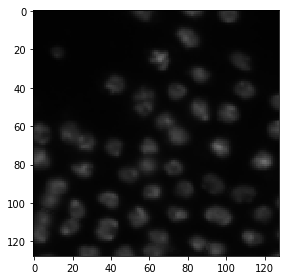

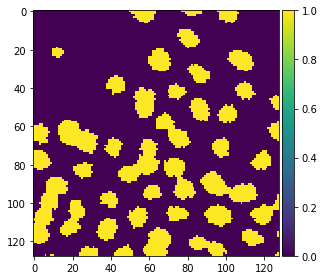

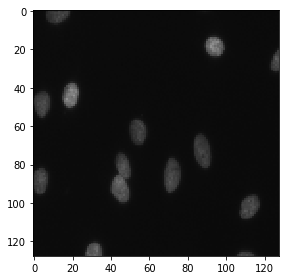

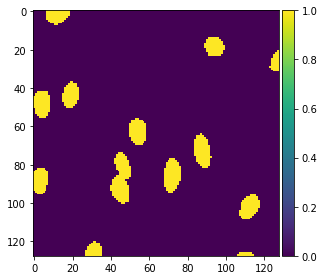

In [0]:
from matplotlib import pyplot as plt
%matplotlib inline

imshow(x.next()[0].astype(np.uint8))
plt.show()

imshow(np.squeeze(y.next()[0].astype(np.uint8)))
plt.show()

imshow(x_val.next()[0].astype(np.uint8))
plt.show()

imshow(np.squeeze(y_val.next()[0].astype(np.uint8)))
plt.show()

In [0]:
train_generator = zip(x, y)
val_generator = zip(x_val, y_val)

In [0]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)

    return K.mean(K.stack(prec), axis=0)

In [0]:
# U-NET
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)


c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)


c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)


c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)


u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)


u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)


u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)


u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)


outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)


model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])

model.summary()

W0117 05:59:07.017880  4024 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0117 05:59:07.034459  4024 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0117 05:59:07.041444  4024 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0117 05:59:07.060394  4024 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0117 05:59:07.071371  4024 depreca

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [0]:
earlystopper = EarlyStopping(patience=3, verbose=1)
checkpointer = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

results = model.fit_generator(train_generator, validation_data=val_generator, validation_steps=10, steps_per_epoch=250,
                              epochs=3, callbacks=[earlystopper, checkpointer])

Epoch 1/3


185/250 [=====================>........] - ETA: 19:07 - loss: 0.9215 - mean_iou: 0.0000e+0 - ETA: 12:55 - loss: 0.8092 - mean_iou: 0.1892    - ETA: 10:41 - loss: 0.7449 - mean_iou: 0.261 - ETA: 9:35 - loss: 0.6867 - mean_iou: 0.302 - ETA: 8:55 - loss: 0.6611 - mean_iou: 0.32 - ETA: 8:28 - loss: 0.6281 - mean_iou: 0.34 - ETA: 8:09 - loss: 0.6267 - mean_iou: 0.36 - ETA: 7:52 - loss: 0.6577 - mean_iou: 0.37 - ETA: 7:40 - loss: 0.6379 - mean_iou: 0.37 - ETA: 7:29 - loss: 0.6268 - mean_iou: 0.38 - ETA: 7:23 - loss: 0.6123 - mean_iou: 0.38 - ETA: 7:19 - loss: 0.6079 - mean_iou: 0.39 - ETA: 7:14 - loss: 0.5983 - mean_iou: 0.39 - ETA: 7:12 - loss: 0.5846 - mean_iou: 0.39 - ETA: 7:10 - loss: 0.5725 - mean_iou: 0.39 - ETA: 7:06 - loss: 0.5574 - mean_iou: 0.40 - ETA: 7:00 - loss: 0.5511 - mean_iou: 0.40 - ETA: 6:54 - loss: 0.5440 - mean_iou: 0.40 - ETA: 6:50 - loss: 0.5351 - mean_iou: 0.40 - ETA: 6:49 - loss: 0.5273 - mean_iou: 0.40 - ETA: 6:48 - loss: 0.5193 - mean_iou: 0.41 - ETA: 6:47 - loss: 

186/250 [=====================>........] - ETA: 5:07 - loss: 0.2890 - mean_iou: 0.69 - ETA: 5:29 - loss: 0.2265 - mean_iou: 0.69 - ETA: 5:34 - loss: 0.1921 - mean_iou: 0.69 - ETA: 5:35 - loss: 0.1734 - mean_iou: 0.69 - ETA: 5:36 - loss: 0.1598 - mean_iou: 0.69 - ETA: 5:36 - loss: 0.1531 - mean_iou: 0.69 - ETA: 5:35 - loss: 0.1534 - mean_iou: 0.69 - ETA: 5:34 - loss: 0.1464 - mean_iou: 0.69 - ETA: 5:34 - loss: 0.1453 - mean_iou: 0.69 - ETA: 5:33 - loss: 0.1427 - mean_iou: 0.69 - ETA: 5:31 - loss: 0.1402 - mean_iou: 0.69 - ETA: 5:30 - loss: 0.1439 - mean_iou: 0.69 - ETA: 5:29 - loss: 0.1418 - mean_iou: 0.69 - ETA: 5:28 - loss: 0.1462 - mean_iou: 0.69 - ETA: 5:27 - loss: 0.1452 - mean_iou: 0.69 - ETA: 5:26 - loss: 0.1441 - mean_iou: 0.69 - ETA: 5:24 - loss: 0.1435 - mean_iou: 0.69 - ETA: 5:23 - loss: 0.1410 - mean_iou: 0.69 - ETA: 5:22 - loss: 0.1364 - mean_iou: 0.69 - ETA: 5:20 - loss: 0.1388 - mean_iou: 0.69 - ETA: 5:19 - loss: 0.1381 - mean_iou: 0.69 - ETA: 5:19 - loss: 0.1387 - mean_i

250/250 [==============================] - ETA: 1:27 - loss: 0.1170 - mean_iou: 0.72 - ETA: 1:26 - loss: 0.1173 - mean_iou: 0.72 - ETA: 1:24 - loss: 0.1172 - mean_iou: 0.72 - ETA: 1:23 - loss: 0.1169 - mean_iou: 0.72 - ETA: 1:21 - loss: 0.1167 - mean_iou: 0.72 - ETA: 1:20 - loss: 0.1169 - mean_iou: 0.72 - ETA: 1:19 - loss: 0.1167 - mean_iou: 0.72 - ETA: 1:17 - loss: 0.1166 - mean_iou: 0.72 - ETA: 1:16 - loss: 0.1165 - mean_iou: 0.72 - ETA: 1:14 - loss: 0.1165 - mean_iou: 0.72 - ETA: 1:13 - loss: 0.1166 - mean_iou: 0.72 - ETA: 1:12 - loss: 0.1165 - mean_iou: 0.72 - ETA: 1:10 - loss: 0.1164 - mean_iou: 0.72 - ETA: 1:09 - loss: 0.1164 - mean_iou: 0.72 - ETA: 1:07 - loss: 0.1165 - mean_iou: 0.72 - ETA: 1:06 - loss: 0.1166 - mean_iou: 0.72 - ETA: 1:05 - loss: 0.1165 - mean_iou: 0.72 - ETA: 1:03 - loss: 0.1163 - mean_iou: 0.72 - ETA: 1:02 - loss: 0.1163 - mean_iou: 0.72 - ETA: 1:00 - loss: 0.1161 - mean_iou: 0.72 - ETA: 59s - loss: 0.1162 - mean_iou: 0.7233 - ETA: 58s - loss: 0.1163 - mean_i

186/250 [=====================>........] - ETA: 5:49 - loss: 0.0907 - mean_iou: 0.75 - ETA: 6:01 - loss: 0.1102 - mean_iou: 0.75 - ETA: 6:06 - loss: 0.1063 - mean_iou: 0.75 - ETA: 6:12 - loss: 0.1186 - mean_iou: 0.75 - ETA: 6:12 - loss: 0.1179 - mean_iou: 0.75 - ETA: 6:10 - loss: 0.1202 - mean_iou: 0.75 - ETA: 6:09 - loss: 0.1100 - mean_iou: 0.75 - ETA: 6:16 - loss: 0.1035 - mean_iou: 0.75 - ETA: 6:16 - loss: 0.1039 - mean_iou: 0.75 - ETA: 6:08 - loss: 0.1051 - mean_iou: 0.75 - ETA: 6:01 - loss: 0.1013 - mean_iou: 0.75 - ETA: 5:55 - loss: 0.1019 - mean_iou: 0.75 - ETA: 5:49 - loss: 0.1079 - mean_iou: 0.75 - ETA: 5:44 - loss: 0.1132 - mean_iou: 0.75 - ETA: 5:40 - loss: 0.1097 - mean_iou: 0.75 - ETA: 5:38 - loss: 0.1110 - mean_iou: 0.75 - ETA: 5:34 - loss: 0.1094 - mean_iou: 0.75 - ETA: 5:32 - loss: 0.1098 - mean_iou: 0.75 - ETA: 5:29 - loss: 0.1064 - mean_iou: 0.75 - ETA: 5:26 - loss: 0.1076 - mean_iou: 0.75 - ETA: 5:23 - loss: 0.1101 - mean_iou: 0.75 - ETA: 5:21 - loss: 0.1091 - mean_i

In [0]:
model = load_model('model.h5', custom_objects={'mean_iou': mean_iou})
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(resize(np.squeeze(preds_test[i]), 
                                       (sizes_test[i][0], sizes_test[i][1]), 
                                       mode='constant', preserve_range=True))

65/65 [==============================] - ETA:  - ETA:  - 2s 25ms/step


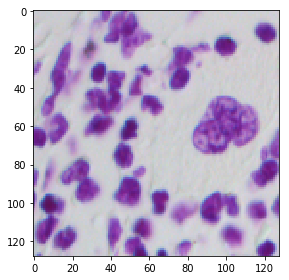

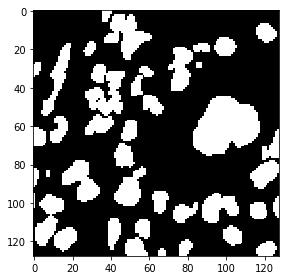

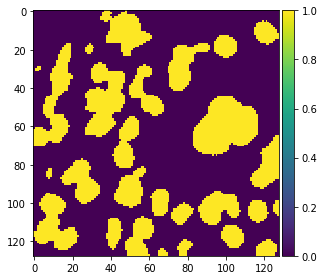

In [0]:
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

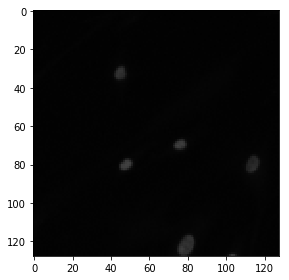

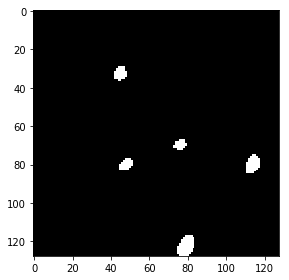

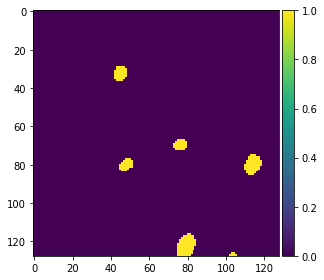

In [0]:
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()